# Group 5

# CUSTOMER SEGMENTATION PROJECT

Mr Ken owns a supermarket mall and through membership cards , he has some basic data about his
customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something he assigns to the customer based on defined parameters like customer
behavior and purchasing data.
Mr Ken wants to understand the customers who can easily converge [Target Customers] so that the
sense can be given to the marketing team and plan the strategy accordingly. He has reached out to
your team for help.
After successful completion of the project, you are expected to prepare a report detailing your data
analysis and information of algorithms used to develop models for segmentation.

In [444]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns


In [445]:
#Import Online Retail Data containing transactions
online = pd.read_csv('data2.csv', encoding = 'unicode_escape')
online.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  12/01/2010 08:26       2.55     17850.0  United Kingdom  
1  12/01/2010 08:26       3.39     17850.0  United Kingdom  
2  12/01/2010 08:26       2.75     17850.0  United Kingdom  
3  12/01/2010 08:26       3.39     17850.0  United Kingdom  
4  12/01/2010 08:26       3.39     17850.0  United Kingdom

In [446]:
#Check the number of columns and rows in the dataset
online.shape

(541909, 8)

In [447]:
#Check for missing values in the dataset
online.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [448]:
#Remove missing values from CustomerID column
online = online[pd.notnull(online['CustomerID'])]

#Validate if there are any negative values in Quantity column
online.Quantity.min()

-80995

In [449]:
#Filter out records with negative values
online = online[(online['Quantity']>0)]

In [450]:
#Validate if there are any negative values in UnitPrice column
online.UnitPrice.min()

0.0

In [451]:
#Convert the string date field to datetime
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [452]:
#Add new column depicting total amount
online['TotalAmount'] = online['Quantity'] * online['UnitPrice']

In [453]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
online.shape

(397924, 9)

In [454]:
print('Min:{}; Max:{}'.format(min(online.InvoiceDate),
max(online.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [455]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

In [456]:
#Create RFM Modelling scores for each customer
RFMScores = online.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'MonetaryValue'}, inplace=True)
RFMScores.reset_index().head()

CustomerID  Recency  Frequency  MonetaryValue
0     12346.0      326          1       77183.60
1     12347.0        2        182        4310.00
2     12348.0       75         31        1797.24
3     12349.0       19         73        1757.55
4     12350.0      310         17         334.40

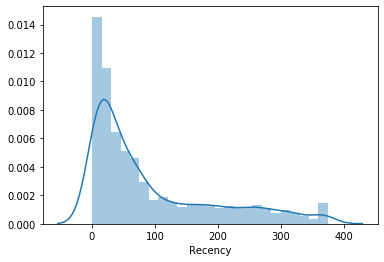

In [457]:
sns.distplot(RFMScores['Recency'])
plt.show()

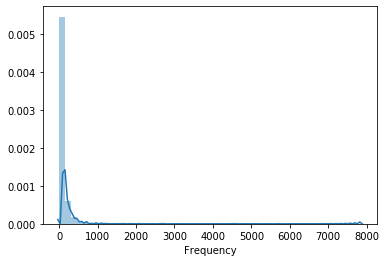

In [458]:
sns.distplot(RFMScores['Frequency'])
plt.show()

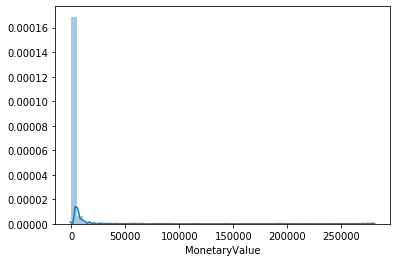

In [459]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
sns.distplot(RFMScores['MonetaryValue'])
plt.show()

In [460]:
#calculate quartile value for each column and name then R, F, M
r_labels = range(4, 0, -1)
f_labels = range(1,5)
m_labels = range(1,5)

r_quartiles = pd.qcut(RFMScores['Recency'], 4, labels = r_labels)
f_quartiles = pd.qcut(RFMScores['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(RFMScores['MonetaryValue'], 4, labels = m_labels)

RFMScores = RFMScores.assign(R = r_quartiles.values)
RFMScores = RFMScores.assign(F = f_quartiles.values)
RFMScores = RFMScores.assign(M = m_quartiles.values)

RFMScores.head()

Recency  Frequency  MonetaryValue  R  F  M
CustomerID                                            
12346.0         326          1       77183.60  1  1  4
12347.0           2        182        4310.00  4  4  4
12348.0          75         31        1797.24  2  2  4
12349.0          19         73        1757.55  3  3  4
12350.0         310         17         334.40  1  1  2

In [461]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFMScores['RFM_Segment'] = RFMScores.apply(join_rfm, axis=1)
RFMScores['RFM_Score'] = RFMScores[['R','F','M']].sum(axis=1)
RFMScores.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  RFM_Score
CustomerID                                                                   
12346.0         326          1       77183.60  1  1  4         114        6.0
12347.0           2        182        4310.00  4  4  4         444       12.0
12348.0          75         31        1797.24  2  2  4         224        8.0
12349.0          19         73        1757.55  3  3  4         334       10.0
12350.0         310         17         334.40  1  1  2         112        4.0

In [462]:
#Analysing RFM Segments
#Largest RFM segments
RFMScores.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

#Select bottom RFM segment "111" and view top 5 rows
RFMScores[RFMScores['RFM_Segment']=='111']

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  RFM_Score
CustomerID                                                                   
12353.0         204          4          89.00  1  1  1         111        3.0
12361.0         287         10         189.90  1  1  1         111        3.0
12401.0         303          5          84.30  1  1  1         111        3.0
12402.0         323         11         225.60  1  1  1         111        3.0
12441.0         367         11         173.55  1  1  1         111        3.0
...             ...        ...            ... .. .. ..         ...        ...
18224.0         264         10         158.95  1  1  1         111        3.0
18227.0         218          5          93.75  1  1  1         111        3.0
18269.0         366          7         168.60  1  1  1         111        3.0
18280.0         278         10         180.60  1  1  1         111        3.0
18281.0         181          7          80.82  1  1  1         111        3.0

[384 rows x 8 columns]

In [463]:
# Summary statistics
RFMScores.groupby('RFM_Score').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         260.8       8.2         158.9   384
4.0         175.7      13.6         239.6   383
5.0         154.3      21.4         368.5   516
6.0          96.3      27.9         824.0   461
7.0          79.1      38.5         755.5   459
8.0          64.6      56.8         994.1   454
9.0          46.0      80.0        1801.4   417
10.0         32.1     112.3        2049.4   426
11.0         21.1     187.7        4083.2   392
12.0          7.3     374.5        9319.2   447

In [490]:
#Assign Loyalty Level to each customer

def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'

RFMScores['General_Segment'] = RFMScores.apply(segment_me, axis=1)

RFMScores.groupby('General_Segment').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            218.3      10.9         199.2   767
Gold               26.4     191.5        4393.9  1682
Silver            100.4      35.7         723.9  1890

In [491]:
# #Validate the data for lowest RFM_Segment: 111 is Bronze
RFMScores[RFMScores['RFM_Segment']=='111'].sort_values('MonetaryValue', ascending=False).reset_index().head(10)

CustomerID  Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  \
0     17334.0      302         11         307.02  1  1  1         111   
1     15087.0      282         15         306.94  1  1  1         111   
2     13762.0      219          7         306.72  1  1  1         111   
3     13718.0      246         12         306.55  1  1  1         111   
4     17176.0      202         15         306.13  1  1  1         111   
5     15219.0      176          9         305.75  1  1  1         111   
6     18220.0      227          2         305.28  1  1  1         111   
7     16217.0      235         15         304.25  1  1  1         111   
8     18185.0      249         17         304.25  1  1  1         111   
9     14248.0      318          8         302.58  1  1  1         111   

   RFM_Score  Cluster Color General_Segment  
0        3.0        0   red          Bronze  
1        3.0        0   red          Bronze  
2        3.0        0   red          Bronze  
3        3.0        0   red          Bronze  
4        3.0        0   red          Bronze  
5        3.0        0   red          Bronze  
6        3.0        0   red          Bronze  
7        3.0        0   red          Bronze  
8        3.0        0   red          Bronze  
9        3.0        0   red          Bronze

In [466]:
# import plotly.offline as po
# import plotly.graph_objs as gobj

# #Frequency Vs Monetary
# graph = RFMScores.query("MonetaryValue < 50000 and Frequency < 2000")

# plot_data = [
#     gobj.Scatter(
#         x=graph.query("General_Segment == 'Bronze'")['Frequency'],
#         y=graph.query("General_Segment == 'Bronze'")['MonetaryValue'],
#         mode='markers',
#         name='Bronze',
#         marker= dict(size= 7,
#             line= dict(width=1),
#             color= 'blue',
#             opacity= 0.8
#            )
#     ),
#         gobj.Scatter(
#         x=graph.query("General_Segment == 'Silver'")['Frequency'],
#         y=graph.query("General_Segment == 'Silver'")['MonetaryValue'],
#         mode='markers',
#         name='Silver',
#         marker= dict(size= 9,
#             line= dict(width=1),
#             color= 'green',
#             opacity= 0.5
#            )
#     ),
#         gobj.Scatter(
#         x=graph.query("General_Segment == 'Gold'")['Frequency'],
#         y=graph.query("General_Segment == 'Gold'")['MonetaryValue'],
#         mode='markers',
#         name='Gold',
#         marker= dict(size= 11,
#             line= dict(width=1),
#             color= 'red',
#             opacity= 0.9
#            )
#     ),
 
# ]

# plot_layout = gobj.Layout(
#         yaxis= {'title': "MonetaryValue"},
#         xaxis= {'title': "Frequency"},
#         title='Segments'
#     )
# fig = gobj.Figure(data=plot_data, layout=plot_layout)
# po.iplot(fig)

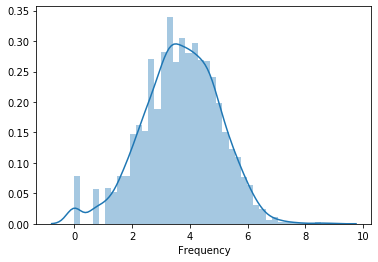

In [467]:
frequency_log= np.log(RFMScores['Frequency'])
sns.distplot(frequency_log)
plt.show()

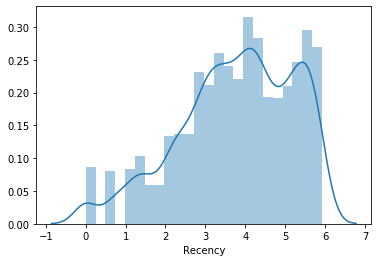

In [468]:
recency_log= np.log(RFMScores['Recency'])
sns.distplot(recency_log)
plt.show()

In [469]:
RFMScores.describe()

Recency    Frequency  MonetaryValue    RFM_Score
count  4339.000000  4339.000000    4339.000000  4339.000000
mean     92.518322    91.708689    2053.793018     7.504955
std     100.009747   228.792852    8988.248381     2.816529
min       1.000000     1.000000       0.000000     3.000000
25%      18.000000    17.000000     307.245000     5.000000
50%      51.000000    41.000000     674.450000     7.000000
75%     142.000000   100.000000    1661.640000    10.000000
max     374.000000  7847.000000  280206.020000    12.000000

In [470]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(RFMScores)
datamart_normalized = scaler.transform(RFMScores)

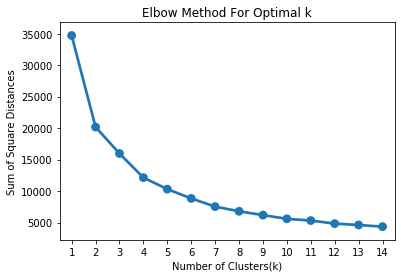

In [471]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(datamart_normalized)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [472]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(datamart_normalized)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                      
12346.0         326          1       77183.60  1  1  4         114        6.0   
12347.0           2        182        4310.00  4  4  4         444       12.0   
12348.0          75         31        1797.24  2  2  4         224        8.0   
12349.0          19         73        1757.55  3  3  4         334       10.0   
12350.0         310         17         334.40  1  1  2         112        4.0   

            Cluster  
CustomerID           
12346.0           0  
12347.0           1  
12348.0           2  
12349.0           1  
12350.0           0

In [473]:
datamart_rfm_k2 = RFMScores.assign(Cluster = cluster_labels)

In [474]:
#Calculate average RFM values and size for each cluster:
datamart_rfm_k2.groupby(['Cluster']).agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          25.0     192.0        4400.0  1672
1         248.0      28.0         631.0  1073
2          59.0      30.0         550.0  1594

<Figure size 504x504 with 0 Axes>

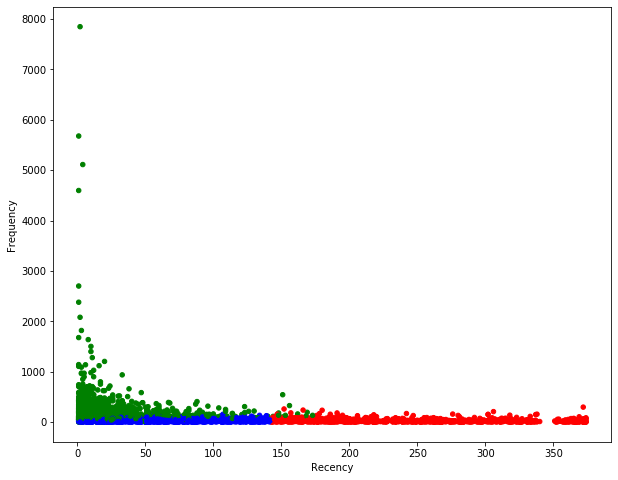

In [487]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)

In [488]:
RFMScores.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                      
12346.0         326          1       77183.60  1  1  4         114        6.0   
12347.0           2        182        4310.00  4  4  4         444       12.0   
12348.0          75         31        1797.24  2  2  4         224        8.0   
12349.0          19         73        1757.55  3  3  4         334       10.0   
12350.0         310         17         334.40  1  1  2         112        4.0   

            Cluster  Color  
CustomerID                  
12346.0           0    red  
12347.0           1  green  
12348.0           2   blue  
12349.0           1  green  
12350.0           0    red

In [476]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=3, random_state=1)
# kmeans.fit(datamart_normalized)
# cluster_labels = kmeans.labels_

In [477]:
# datamart_normalized = pd.DataFrame(datamart_normalized,
# index=RFMScores.index,
# columns=RFMScores.columns)
# datamart_normalized['Cluster'] = datamart_rfm_k2['Cluster']

In [478]:
# datamart_melt = pd.melt(datamart_normalized.reset_index(),
# id_vars=['CustomerID', 'Cluster'],
# value_vars=['Recency', 'Frequency', 'MonetaryValue'],
# var_name='Attribute',
# value_name='Value')

In [479]:
# plt.title('Snake plot of standardized variables')
# sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

In [480]:
# cluster_avg = datamart_rfm_k2.groupby(['Cluster']).mean()
# population_avg = RFMScores.mean()
# relative_imp = cluster_avg / population_avg - 1

In [483]:
# relative_imp.round(2)

In [482]:
# plt.figure(figsize=(8, 2))
# plt.title('Relative importance of attributes')
# sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
# plt.show()